### Machine Learning Developer - Assessment
Tasks:

1) Data Preparation: 
- Clean and convert the data to make it suitable for time-series analysis.

2) Grouping Method: 
- Develop a method to group the tickers into subgroups.
- These groups can be based on any characteristics or assumptions.
- What assumptions did you make?
- What characteristics did you consider when grouping?

3) Predictive Modeling: 
- Select all tickers or tickers from any subgroup and build a time-series predictive model. You may choose one or multiple time-series data (e.g., open, close, high, low, or volume) as inputs and apply any feature engineering techniques you find suitable. The model should predict one of the time-series data (e.g., open, close, high, low, or volume).
- What feature engineering methods did you use? Does the model perform well across all tickers?

Requirements:
You must use any machine learning package to build the predictive model. There are no restrictions on the choice of the model, but you should not use time-series statistical packages for building the model. However, you may use these statistical packages for analytical purposes.
Provide a downloadable link (e.g., online drives or Google Colab) that includes the following items:
A notebook with the code and answers to the questions.
The saved model.

In [1]:
# standard import
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [2]:
# load the files
df_info = pd.read_parquet('/Users/jiayikoh/Downloads/interview_THA/Interview_info.parquet')
df_test = pd.read_parquet('/Users/jiayikoh/Downloads/interview_THA/Interview_test.parquet')
df_1 = pd.read_parquet('/Users/jiayikoh/Downloads/interview_THA/Interview.parquet')

In [3]:
# check the df_info
df_info

,indicator,title,description,unittype
0,open,Open Price - Split Adjusted,The official exchange opening price; adjusted ...,USD/share
1,ticker,Ticker Symbol,Anonymized ticker symbol.The ticker is a uniqu...,text
2,date,Price Date,The trade date of the price observations.,date (YYYY-MM-DD)
3,high,High Price - Split Adjusted,The high share price; adjusted for stock split...,USD/share
4,low,Low Price - Split Adjusted,The low share price; adjusted for stock splits...,USD/share
5,close,Close Price - Split Adjusted,The official exchange close price; adjusted fo...,USD/share
6,volume,Volume - Split Adjusted,The daily traded volume across all exchanges; ...,numeric
7,closeadj,Close Price - Adjusted for Splits Dividends an...,The official exchange close price; adjusted fo...,USD/share
8,closeunadj,Close Price - Unadjusted,The official exchange close price; not adjuste...,USD/share


In [4]:
# check the columns legend
for _, text in enumerate(df_info['description']):
    print(text)

The official exchange opening price; adjusted for stock splits and stock dividends. Not adjusted for cash dividends or spinoffs.
Anonymized ticker symbol.The ticker is a unique identifier for a security in the database
The trade date of the price observations.
The high share price; adjusted for stock splits and stock dividends. Not adjusted for cash dividends or spinoffs.
The low share price; adjusted for stock splits and stock dividends. Not adjusted for cash dividends or spinoffs.
The official exchange close price; adjusted for stock splits and stock dividends. Not adjusted for cash dividends or spinoffs.
The daily traded volume across all exchanges; adjusted for stock splits and stock dividends. Not adjusted for cash dividends or spinoffs. Includes opening and closing cross volumes if applicable.
The official exchange close price; adjusted for stock splits; stock dividends; cash dividends and spinoffs.
The official exchange close price; not adjusted for stock splits; stock dividends

In [5]:
# have a first glance at df_1
df_1.head()

,date,open,high,low,close,volume,closeadj,closeunadj,ticker
0,2024-01-30,18.80,18.87,18.67,18.77,44712.0,18.77,18.77,EkEuXFUQrK
1,2024-04-04,20.02,20.22,20.02,20.22,17117.0,20.22,20.22,EkEuXFUQrK
2,2024-04-04,10.24,10.24,10.24,10.24,973.0,10.24,10.24,ZL4m1dXqNc
3,2024-04-03,10.30,10.30,10.30,10.30,0.0,10.30,10.30,ZL4m1dXqNc
4,2024-04-04,180.20,184.43,179.75,181.57,945184.0,181.57,181.57,31cWpkAP9J


#### Data Pre-processing
- Make it a time-series suitable data will require to set the dates as the index

In [12]:
# will set the date as the index as datetime
df_1.set_index('date', inplace=True, drop=True)

In [14]:
# sort the date in ascending order
df_1.sort_index(ascending=True, inplace=True)

#### Data pre-processing
- check for null values, duplicates and extreme values especially for the adjusted close price before performing any data manipulation technique
- Asset prices are usually non-stationary. Will transform prices to returns (can be simple returns or log returns)

In [16]:
# check the data format and null values
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 862463 entries, 2024-01-02 to 2024-06-28
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   open        862463 non-null  float64
 1   high        862463 non-null  float64
 2   low         862463 non-null  float64
 3   close       862463 non-null  float64
 4   volume      862463 non-null  float64
 5   closeadj    862463 non-null  float64
 6   closeunadj  862463 non-null  float64
 7   ticker      862463 non-null  object 
dtypes: float64(7), object(1)
memory usage: 59.2+ MB


##### There is no null value observes
1) check duplicated values

2) check extreme values
- (will not do this as there are too many unique tickers to be plotted) next will plot the data to check for extreme values (data reasonableness check)
- Instead, I will check for sudden price jumps or drops (more than 100% and less than -50%)

3) sample visual inspection

In [17]:
# check for duplicated rows
df_1[df_1.duplicated()]

,open,high,low,close,volume,closeadj,closeunadj,ticker
date,,,,,,,,
2024-01-03,13.340,13.340,13.340,13.340,0.0,13.340,13.340,PMkimMg3Py
2024-01-03,10.840,10.840,10.840,10.840,0.0,10.840,10.840,mrCsXZCmJS
2024-01-03,10.890,10.890,10.890,10.890,0.0,10.890,10.890,zznnufCQ9n
2024-01-03,0.050,0.050,0.050,0.050,0.0,0.050,0.050,4Oxcl96Jo8
2024-01-03,10.600,10.600,10.600,10.600,0.0,10.600,10.600,1TqhCo7f1U
...,...,...,...,...,...,...,...,...
2024-06-28,11.880,11.880,11.880,11.880,65.0,11.880,11.880,d6OO0oZ55s
2024-06-28,17.000,17.000,17.000,17.000,0.0,17.000,17.000,zA5xic0aam
2024-06-28,11.600,11.600,11.600,11.600,0.0,11.600,11.600,1AUVAfNRmV


In [19]:
# it looks like there are tickers that are not liquid with the minimal volume traded
df_1[(df_1['ticker'] == 'PMkimMg3Py') & (df_1['open'] == 13.340)]

,open,high,low,close,volume,closeadj,closeunadj,ticker
date,,,,,,,,
2024-01-02,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py
2024-01-03,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py
2024-01-04,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py
2024-01-05,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py
2024-01-08,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py
...,...,...,...,...,...,...,...,...
2024-04-02,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py
2024-04-03,13.34,13.34,13.34,13.34,2.0,13.34,13.34,PMkimMg3Py
2024-04-04,13.34,13.34,13.34,13.34,0.0,13.34,13.34,PMkimMg3Py


In [27]:
# create new columns for simple and log returns
df_1['simple_return'] = df_1.groupby('ticker')['closeadj'].pct_change()
df_1['log_return'] = df_1.groupby('ticker')['closeadj'].transform(lambda x: np.log(x / x.shift(1)))

In [30]:
# inspect one of the ticker data
df_1[df_1['ticker'] == '00CqTIPkWB']

,open,high,low,close,volume,closeadj,closeunadj,ticker,simple_return,log_return
date,,,,,,,,,,
2024-01-02,67.26,67.270,65.220,65.50,63694.0,65.305,65.50,00CqTIPkWB,NaN,NaN
2024-01-03,65.30,66.055,64.450,64.50,75988.0,64.308,64.50,00CqTIPkWB,-0.015267,-0.015385
2024-01-04,64.78,65.220,64.010,64.36,42099.0,64.169,64.36,00CqTIPkWB,-0.002161,-0.002164
2024-01-05,63.88,64.350,62.865,63.57,78645.0,63.381,63.57,00CqTIPkWB,-0.012280,-0.012356
2024-01-08,63.60,64.550,63.600,64.20,74639.0,64.009,64.20,00CqTIPkWB,0.009908,0.009860
...,...,...,...,...,...,...,...,...,...,...
2024-06-24,64.75,64.965,63.830,63.89,124268.0,63.890,63.89,00CqTIPkWB,-0.014955,-0.015068
2024-06-25,63.67,63.750,62.900,63.60,52331.0,63.600,63.60,00CqTIPkWB,-0.004539,-0.004549
2024-06-26,63.32,64.440,62.070,64.38,80020.0,64.380,64.38,00CqTIPkWB,0.012264,0.012190


In [31]:
# check for sudden price jumps or drops
unusual_pricechange = df_1[(df_1['simple_return']>1) | (df_1['simple_return'] < -0.5)]

In [32]:
unusual_pricechange

,open,high,low,close,volume,closeadj,closeunadj,ticker,simple_return,log_return
date,,,,,,,,,,
2024-01-03,18.950,19.000,5.850,7.400,2281854.6,7.400,1.480,6KLcybx3u6,-0.612565,-0.948208
2024-01-03,7.350,10.970,5.870,6.200,61280777.0,6.200,6.200,2zenmed88g,1.610526,0.959552
2024-01-03,0.041,0.282,0.030,0.194,24172.0,0.194,0.194,iP0zNrRx82,5.689655,1.900562
2024-01-03,0.005,0.005,0.005,0.005,1259.0,0.005,0.005,vtIiPABfvU,-0.583333,-0.875469
2024-01-03,0.030,0.090,0.030,0.090,138675.0,0.090,0.090,QuI4OOAJrj,2.750000,1.321756
...,...,...,...,...,...,...,...,...,...,...
2024-06-27,0.047,0.208,0.047,0.170,209259.0,0.170,0.170,tbAe5gtHgb,2.400000,1.223775
2024-06-27,0.025,0.025,0.025,0.025,100.0,0.025,0.025,8Qku8dbBbs,1.272727,0.820981
2024-06-27,0.043,0.043,0.010,0.020,334884.0,0.020,0.020,8LvEWx72WB,-0.600000,-0.916291


In [33]:
# inspecting one of the ticker data that has incredible movement in price
df_1[df_1['ticker'] == '6KLcybx3u6']

,open,high,low,close,volume,closeadj,closeunadj,ticker,simple_return,log_return
date,,,,,,,,,,
2024-01-02,19.200,19.550,19.050,19.100,295904.2,19.100,3.820,6KLcybx3u6,NaN,NaN
2024-01-03,18.950,19.000,5.850,7.400,2281854.6,7.400,1.480,6KLcybx3u6,-0.612565,-0.948208
2024-01-04,6.100,6.200,3.889,3.889,2093256.2,3.889,0.778,6KLcybx3u6,-0.474459,-0.643328
2024-01-05,3.550,4.200,3.451,3.645,912441.6,3.645,0.729,6KLcybx3u6,-0.062741,-0.064796
2024-01-08,3.594,3.645,2.550,2.600,752458.2,2.600,0.520,6KLcybx3u6,-0.286694,-0.337845
...,...,...,...,...,...,...,...,...,...,...
2024-06-24,0.920,0.971,0.900,0.930,4718408.0,0.930,0.930,6KLcybx3u6,0.010870,0.010811
2024-06-25,0.970,1.020,0.930,1.020,4797402.0,1.020,1.020,6KLcybx3u6,0.096774,0.092373
2024-06-26,0.985,1.000,0.950,0.960,1274604.0,0.960,0.960,6KLcybx3u6,-0.058824,-0.060625


<Axes: xlabel='date'>

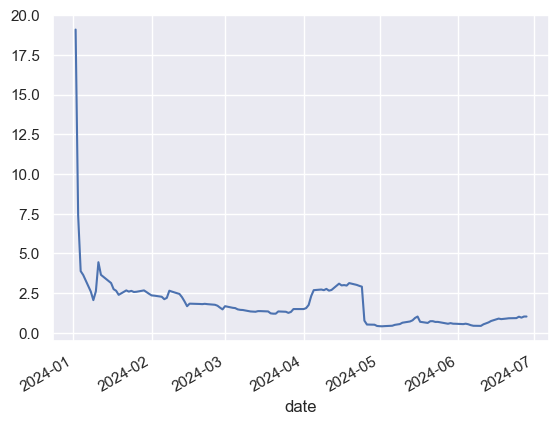

In [34]:
# plot the above closeadj
df_1[df_1['ticker'] == '6KLcybx3u6']['closeadj'].plot()

##### it looks like there is a huge price drop for the above ticker after the first day of 2024

In [42]:
# create a sample based on all the tickers
sample_tickers = df_1['ticker'].unique()[:5] # using the first 5 tickers

# summary statistics for each sample ticker
ticker_summary = df_1[df_1['ticker'].isin(sample_tickers)].groupby('ticker')['simple_return'].describe()
print(ticker_summary)

            count      mean       std       min       25%       50%       75%  \
ticker                                                                          
34Zkn8L95m  123.0  0.000519  0.015330 -0.047262 -0.008794  0.001212  0.010536   
Roq8sZFhJs  123.0  0.010001  0.071928 -0.255556 -0.022181  0.000000  0.043844   
WmCzQF1giJ  123.0  0.008749  0.136361 -0.259887 -0.048501 -0.003960  0.038835   
YiKO4jIWK8  123.0 -0.002429  0.081960 -0.191981 -0.040669 -0.006536  0.025071   
ZyX5XHwtF8  123.0 -0.000793  0.021973 -0.091396 -0.013782 -0.000925  0.009631   

                 max  
ticker                
34Zkn8L95m  0.044945  
Roq8sZFhJs  0.313433  
WmCzQF1giJ  0.911765  
YiKO4jIWK8  0.605263  
ZyX5XHwtF8  0.092061  


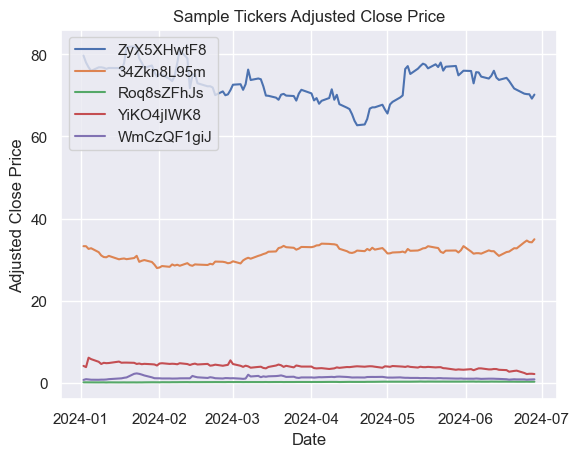

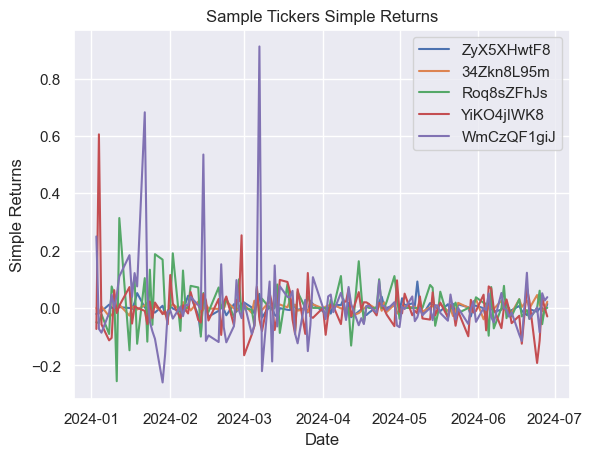

In [43]:
# visual inspection
for ticker in sample_tickers:
    ticker_data = df_1[df_1['ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['closeadj'], label=ticker)
    
plt.title('Sample Tickers Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()


# visual inspection
for ticker in sample_tickers:
    ticker_data = df_1[df_1['ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['simple_return'], label=ticker)
    
plt.title('Sample Tickers Simple Returns')
plt.xlabel('Date')
plt.ylabel('Simple Returns')
plt.legend()
plt.grid(True)
plt.show()

Points to note:
- Plotting the price and the returns together allows us to observe the relationship between price and volatility in returns
- It can be seen that some tickers do have a more volatile returns

There are more than 7000 unique tickers in the dataset. It may not be feasible to fit a model for each of the ticker. One approach is to group the tickers with the similar characteristics and create a model for the each group.

Grouping Method:
1) Assumptions
- Group the tickers based on returns, volatility and trading volume (will consider the sector/industry if given), this is to facilitate any of the strategy deployment in the future (i.e. mean reverting returns/volatility etc) and similar predictive model could be effective for homogenous group

2) Characteristics for grouping
- Returns: grouping by average returns can help segregate growth stocks from stable/defensive ones
- Volatility: tickers with similar volatility patterns may behave similarly in response to any market changes
- Volume: trading volume can indicate liquidity and investor interest, which can influence price predictability
- Stationarity: if the returns or volatility are stationary, these tickers may require different model strategies


In [49]:
# calculate average return, average volatility and average traded volume for each ticker
ticker_stats = df_1.groupby('ticker').agg({
    'log_return': ['mean', 'std'], # mean return and std dev
    'volume': 'mean' # average traded volume
}).reset_index()

In [51]:
# flatten multi-level column
ticker_stats.columns = ['ticker', 'Average_Return', 'Average_Volatility', 'Average_Volume']

In [63]:
ticker_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7251 entries, 0 to 7250
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ticker              7251 non-null   object 
 1   Average_Return      7245 non-null   float64
 2   Average_Volatility  7241 non-null   float64
 3   Average_Volume      7251 non-null   float64
dtypes: float64(3), object(1)
memory usage: 226.7+ KB


Data contains only one day value which return NaN in return and volatility (about 6 tickers). Will fillna with 0 for both for easier manipulation afterwards instead of removing them

In [64]:
ticker_stats.fillna(0, inplace=True)

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# standardize the features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(ticker_stats[['Average_Return', 'Average_Volatility', 'Average_Volume']])

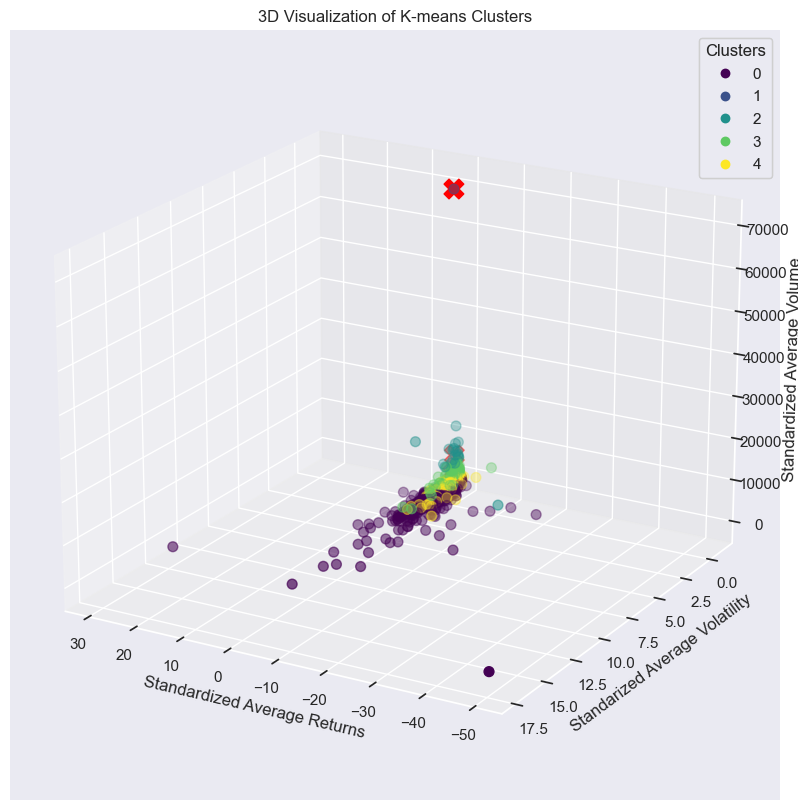

          ticker  Average_Return  Average_Volatility  Average_Volume
0     00CqTIPkWB       -0.000139            0.016730    7.149152e+04
1     00rG1ntZCy       -0.004065            0.044589    6.847784e+05
2     01D9vjijJc        0.000271            0.010118    1.297758e+03
3     01JYWTck2S        0.000801            0.011501    7.364735e+05
4     02CJDrjOPG       -0.000609            0.085063    1.492321e+06
...          ...             ...                 ...             ...
7246  zxZ2JdtJNr       -0.001564            0.075943    2.351698e+04
7247  zxh1cwiuqY        0.000194            0.011866    2.374332e+04
7248  zxvRCQbTJl        0.000850            0.031432    3.000194e+03
7249  zznnufCQ9n        0.000000            0.000000    3.306452e-01
7250  zzvNRhUkJG       -0.003858            0.033222    4.738025e+05

[7251 rows x 4 columns]


In [82]:
# K-means clustering to create subgroups
kmeans = KMeans(n_clusters=5, random_state=42) # adjust n_clusters as needed
ticker_stats['cluster'] = kmeans.fit_predict(features_scaled)

# scale the Z-axis for better visibility
z_scale_factor = 2  # Adjust this factor to scale the Z-axis
features_scaled[:, 2] *= z_scale_factor

# 3D visualization of K-means clusters
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# adjust the view angle for better Z-axis visibility
ax.view_init(elev=20, azim=120)  # Change elev and azim for different angles

# scatterplot using the original scaled features
scatter = ax.scatter(features_scaled[:, 0], features_scaled[:, 1], features_scaled[:, 2],
                     c=ticker_stats['cluster'], cmap='viridis', s=50)

# Centroids visualization
centroids = kmeans.cluster_centers_
centroids[:, 2] *= z_scale_factor  # Apply the same scaling factor to the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=200, c='red', label='Centroids')

# add axis labels and title
ax.set_xlabel('Standardized Average Returns')
ax.set_ylabel('Standarized Average Volatility')
ax.set_zlabel('Standardized Average Volume')
ax.set_title('3D Visualization of K-means Clusters')

# add a legend
legend = ax.legend(*scatter.legend_elements(), title='Clusters', loc='upper right')
ax.add_artist(legend)

plt.show()

print(ticker_stats[['ticker', 'Average_Return', 'Average_Volatility', 'Average_Volume']])

In [84]:
# group by cluster and calculate the mean and count for each cluster
cluster_summary = ticker_stats.groupby('cluster').agg(
    Samples=('ticker', 'size'),
    Avg_Return=('Average_Return', 'mean'),
    Avg_Volatility=('Average_Volatility', 'mean'),
    Avg_Volume=('Average_Volume', 'mean')
)

print(cluster_summary)


         Samples  Avg_Return  Avg_Volatility    Avg_Volume
cluster                                                   
0           6673   -0.001440        0.049601  4.700071e+05
1              1    0.007658        0.032423  4.770188e+08
2             20   -0.017774        0.069977  5.495161e+07
3             89   -0.003734        0.052506  1.946460e+07
4            468   -0.001816        0.044391  5.893620e+06


It seems like the traded volume plays a more important part in the clustering (there is no obvious pattern in the average returns and volatility).

I would like to try reduce it to a two-dimensional clustering by removing traded volume.

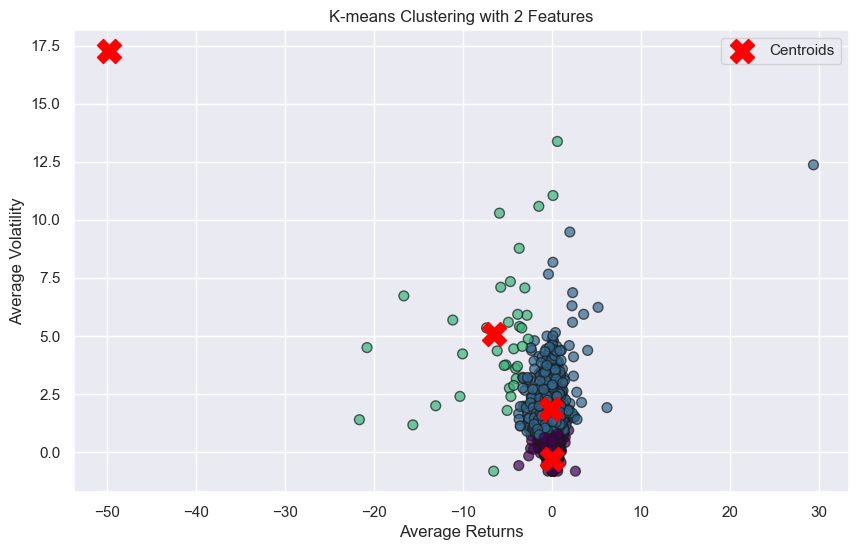

In [101]:
# standardize the features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(ticker_stats[['Average_Return', 'Average_Volatility']])

# K-means clustering to create subgroups
kmeans = KMeans(n_clusters=4, random_state=42) # adjust n_clusters as needed
ticker_stats['cluster'] = kmeans.fit_predict(features_scaled)

# plot the clusters
plt.figure(figsize=(10, 6))

# scatter plot of the data points, colored by cluster
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=ticker_stats['cluster'], cmap='viridis', s=50, alpha=0.7, edgecolor='k')

# plot the centroids of the clusters
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

# add axis labels and title
plt.xlabel('Average Returns')
plt.ylabel('Average Volatility')
plt.title('K-means Clustering with 2 Features')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


It seems that it can be subgrouped into 3

1. Avg return around 0 and low volatility
2. Avg return around 0 and high volatility
3. Negative return and high volatility

#### Creating subgroups based on stationarity check
1) Calculate stationarity
- Check stationarity of daily returns and volatility using ADF
- Create two columns indicating whether the daily returns and volatility are stationary (0 for non-stationary)

2) Group tickers based on stationarity
    - Group 1: Stationary returns and stationary volatility
    - Group 2: Stationary returns and non-stationary volatility
    - Group 3: Non-stationary returns and stationary volatility
    - Group 4: Non-stationary returns and non-stationary volatility 

In [106]:
from statsmodels.tsa.stattools import adfuller

# calculate the daily volatility using a 20-day rolling volatility (a month)
df_1['daily_volatility'] = df_1.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=20).std())


In [110]:
# create a function to check stationarity using the ADF test
def check_stationarity(series, threshold=0.5, min_samples=20):
    """
    Check stationarity of a time series using ADF test
    Returns 1 if stationary (p-value < threshold), otherwise 0
    """
    
    # Check if the series has enough non-NaN values
    if series.dropna().shape[0] < min_samples:
        return 0 # consider as non-stationary if not enough data to perform the test
    
    # check if the series is constant (if there is only 1 unique value, the series is constant)
    if series.nunique() <= 1:
        return 1 # assume constant series as stationary
    else:
        try:
            result = adfuller(series.dropna())
            p_value = result[1]
            return 1 if p_value < threshold else 0
        except ValueError:
            return 0 # assume non-stationary if the test fails


# apply to the dataset
stationarity_results = df_1.groupby('ticker').agg(
    stationary_return = ('log_return', lambda x: check_stationarity(x)),
    stationary_volatility = ('daily_volatility', lambda x: check_stationarity(x))
    
).reset_index()

In [111]:
# merge stationarity resuilts with the main df
df_2 = df_1.merge(stationarity_results, on='ticker', how='left')

# create a combnined label for subgrouping
df_2['stationarity_group'] = df_2['stationary_return'].astype(str) + '-' + df_2['stationary_volatility'].astype(str)

df_2.head()

,open,high,low,close,volume,closeadj,closeunadj,ticker,simple_return,log_return,daily_volatility,stationary_return,stationary_volatility,stationarity_group
0,81.390,81.390,79.110,80.130,344111.0,79.693,80.13,ZyX5XHwtF8,NaN,NaN,NaN,1,1,1-1
1,34.430,34.650,33.740,33.930,4720990.0,33.266,33.93,34Zkn8L95m,NaN,NaN,NaN,1,0,1-0
2,0.084,0.118,0.084,0.100,250978.0,0.100,0.10,Roq8sZFhJs,NaN,NaN,NaN,1,1,1-1
3,4.725,4.725,3.800,4.101,30720.8,4.101,0.82,YiKO4jIWK8,NaN,NaN,NaN,1,1,1-1
4,0.690,0.690,0.690,0.690,360.0,0.690,0.69,WmCzQF1giJ,NaN,NaN,NaN,1,0,1-0


In [115]:
# check the count of subgroup
df_2[['ticker', 'stationarity_group']].drop_duplicates()['stationarity_group'].value_counts()

stationarity_group
1-1    4934
1-0    2200
0-0     114
0-1       3
Name: count, dtype: int64

There are more than 90% of the tickers are expected to have a stationary returns which is a great! Stationary returns make it easier in modelling purposes.

For simplicity, I will not use the Kmeans clusters above in the grouping methodology but this may be useful in portfolio optimization purposes. I will just use the stationarity check to split them into 4 subgroups and proceed to apply machine learning model for prediction purposes.

#### Create predictive models for subgroup
1) Feature engineering
- Stationary returns: Use lagged returns, rolling mean as features
- Non-stationary returns: Use differencing, trend and seasonality components

2) Model selection
- Stationary subgroups: Regression models (Random Forest, Linear Regression - naive model)
- Non-stationary subgroups: More complex models (RNN?)


In [226]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# initialize a dictionary to store models and performance metrics for each subgroup
models = {}
performance = {}

# filter stationarity returns only group
stationary_df = df_2[df_2['stationary_return'] == 1].dropna()

# add lagged returns, rolling mean and rolling standard deviation as features
stationary_df['lag_1'] = stationary_df.groupby('ticker')['log_return'].shift(1)
stationary_df['rolling_mean'] = stationary_df.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=5).mean())
stationary_df['rolling_std'] = stationary_df.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=5).std())
stationary_df['rolling_volume'] = stationary_df.groupby('ticker')['volume'].transform(lambda x: x.rolling(window=5).mean())

# drop na values
stationary_df.dropna(inplace=True)

# split into X and Y train data
X_train = stationary_df[['lag_1', 'rolling_mean', 'rolling_std', 'rolling_volume']]
y_train = stationary_df['log_return']


While preparing the test set, it is important to note that this is a time series data and they are continuous. Since we are using features like lagged returns, rolling mean, rolling std and rolling volume, we have to make sure that the test set will take the historical values from the train set. To achieve this, we will have to concatenate both train and test set to calculate the "features" values before making predictions on the test set. 

Note that: test set is not used for model training

In [228]:
df_test = pd.read_parquet('/Users/jiayikoh/Downloads/interview_THA/Interview_test.parquet')

In [229]:
# prepare the test set features
df_test.set_index('date', inplace=True)
df_test.sort_index(ascending=True, inplace=True)

# concatenate both train and test set
df_combined = pd.concat([df_1, df_test])

# fitler the test dataset to only contain stationary returns tickers
df_combined['log_return'] = df_combined.groupby('ticker')['closeadj'].transform(lambda x: np.log(x / x.shift(1)))
df_combined['lag_1'] = df_combined.groupby('ticker')['log_return'].shift(1)
df_combined['rolling_mean'] = df_combined.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=5).mean())
df_combined['rolling_std'] = df_combined.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=5).std())
df_combined['rolling_volume'] = df_combined.groupby('ticker')['volume'].transform(lambda x: x.rolling(window=5).mean())

# split the combined data back into train and test set
train_df = df_combined.iloc[:len(df_1)].dropna()
test_df = df_combined.iloc[len(df_1):][['log_return', 'lag_1', 'rolling_mean', 'rolling_std', 'rolling_volume', 'ticker']].dropna()

# filter tickers that are stationary only as test set
test_df = test_df[test_df['ticker'].isin(stationary_df['ticker'])]

X_test = test_df[['lag_1', 'rolling_mean', 'rolling_std', 'rolling_volume']]
y_test = test_df['log_return']

Below we will train the model using Random Forest and Linear regression. Save them in pickle files

In [230]:
import pickle

# initialize models
models = {
    'RF': RandomForestRegressor(random_state=42),
    'LR': LinearRegression()
}

# train and evaluate each model
for model_name, model in models.items():
    # train the model
    model.fit(X_train, y_train)
    
    # Save the model to a pickle file
    with open(f"{model_name}_123.pkl", "wb") as file:
        pickle.dump(model, file)
    
    # predict on the test set
    y_pred = model.predict(X_test)
    
    # calculate and store the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    performance[model_name] = mse
    
    print(f"{model_name} - MSE: {mse:.4f}")

RF - MSE: 0.0031
LR - MSE: 0.0029


Below we load the trained model from pickle and make predictions

In [233]:
# load the saved RF model from the pickle file
with open('/Users/jiayikoh/RF_123.pkl', 'rb') as file:
    rf_model = pickle.load(file)
    
# make prediction on the test set
y_pred = rf_model.predict(X_test)

# calculate the MSE
mse = mean_squared_error(y_test, y_pred)


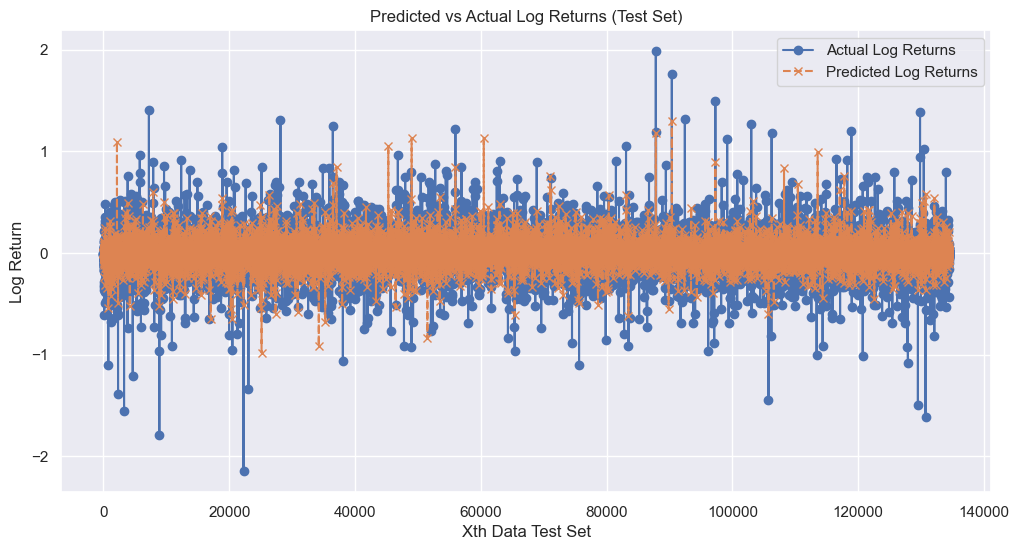

In [234]:
# data visualisation
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Log Returns', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted Log Returns', marker='x', linestyle='--')
plt.title('Predicted vs Actual Log Returns (Test Set)')
plt.xlabel('Xth Data Test Set')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

Try to evaluate the model performance by ticker

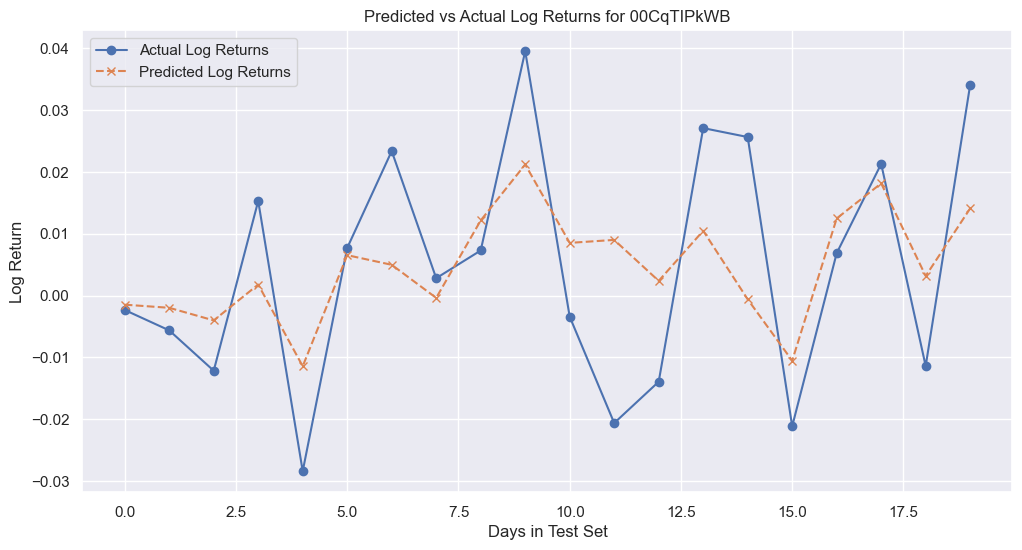

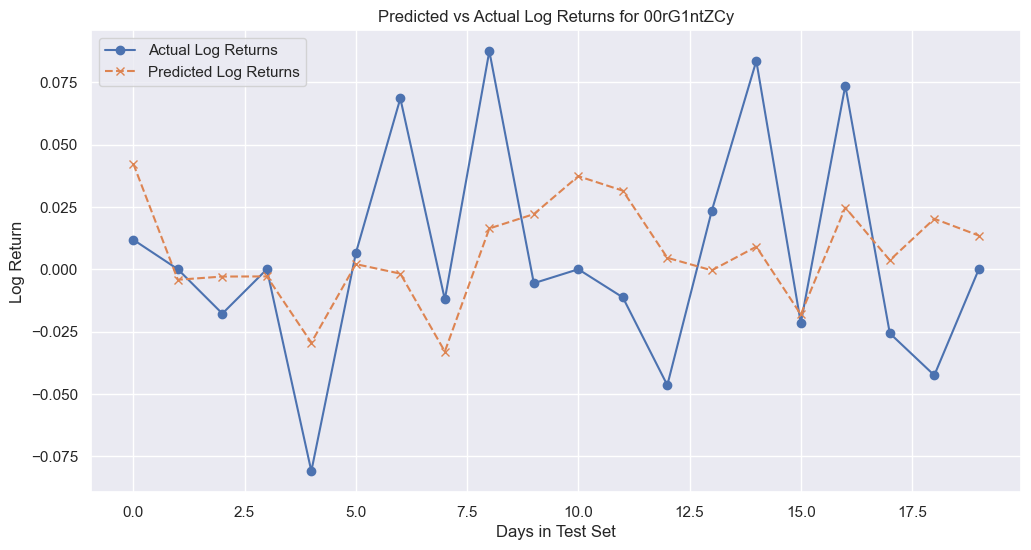

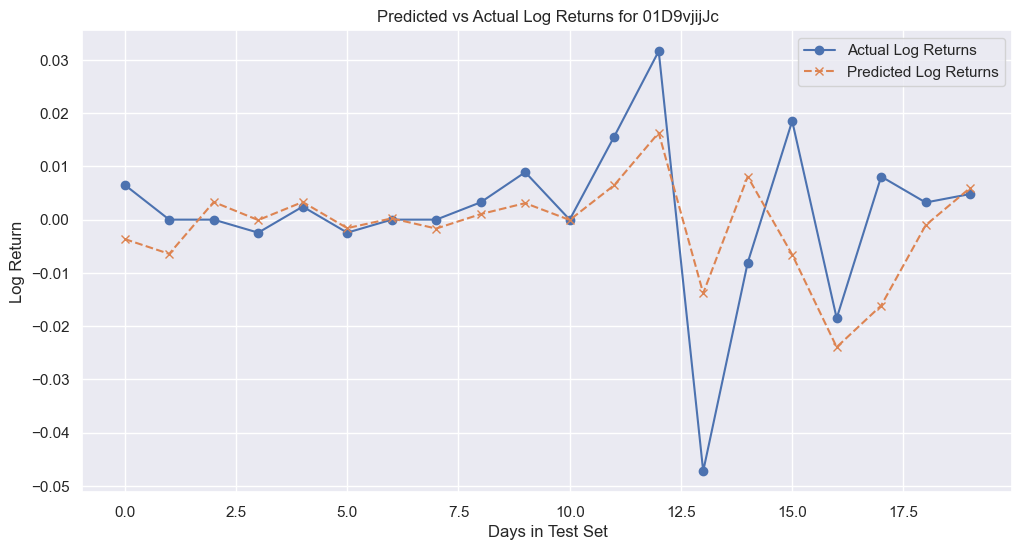

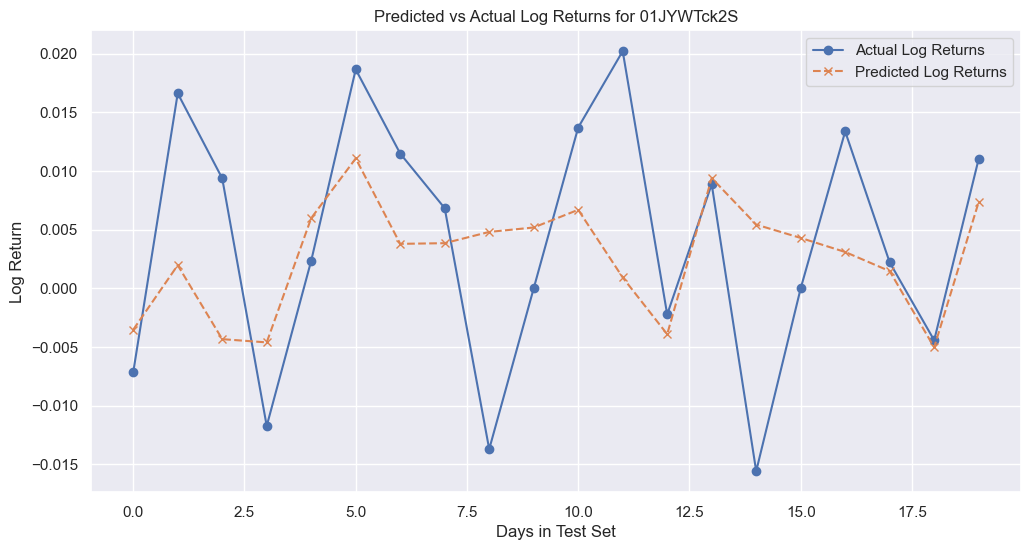

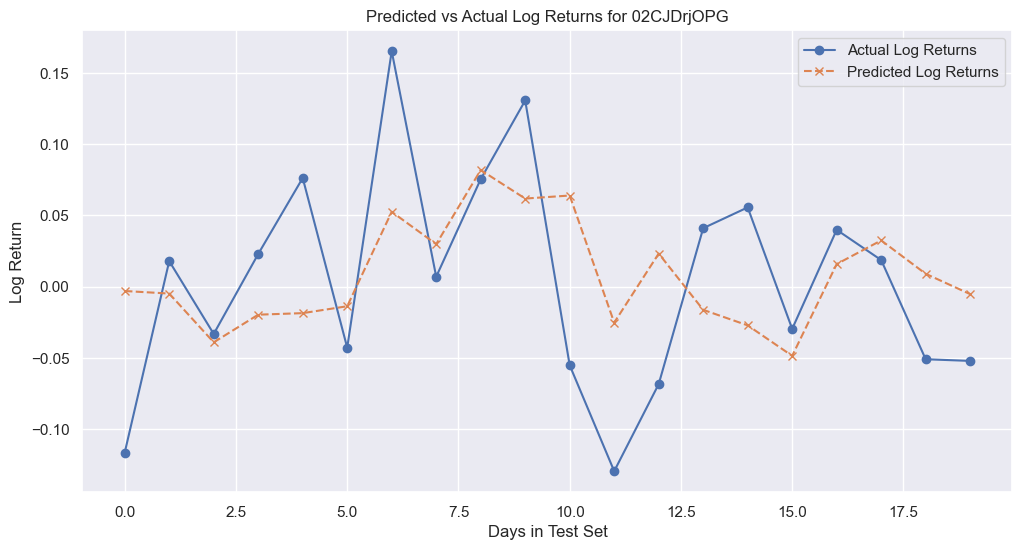

In [236]:
# create a dictionary to store evaluation results for each ticker
ticker_performance = []

# group the test data by ticker and evaluate each one
ticker_count = 0  # Initialize a counter to limit the number of plots
max_tickers_to_plot = 5  # Set the maximum number of tickers to plot

# group the test data by ticker and evaluate each one
for ticker, ticker_df in test_df.groupby('ticker'):
    # prepare the features for this ticker
    X_test = ticker_df[['lag_1', 'rolling_mean', 'rolling_std', 'rolling_volume']]
    
    # ensure that actual values are aligned with the features
    y_test = ticker_df['log_return']
    
    # predict using the loaded model
    y_pred = rf_model.predict(X_test)
    
    # calculate mean squared error for this ticker
    mse = mean_squared_error(y_test, y_pred)
    
    # store the result
    ticker_performance.append({'ticker': ticker, 'mse': mse})
    
    # visualise the first 5 tickers (actual vs predicted log return)
    if ticker_count < max_tickers_to_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.values, label='Actual Log Returns', marker='o', linestyle='-')
        plt.plot(y_pred, label='Predicted Log Returns', marker='x', linestyle='--')
        plt.title(f'Predicted vs Actual Log Returns for {ticker}')
        plt.xlabel('Days in Test Set')
        plt.ylabel('Log Return')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        ticker_count += 1  # Increment the counter
    
    # Stop after plotting 5 tickers
    if ticker_count >= max_tickers_to_plot:
        pass
    
ticker_performance_df = pd.DataFrame(ticker_performance)

In [237]:
ticker_performance_df.sort_values(by='mse')

,ticker,mse
3105,SpRQ0tMMKq,0.000000
1345,CGOD9E3v6J,0.000000
5874,rn0qwnxVCe,0.000000
1368,CQw0F4nDdh,0.000000
2208,KSrSDTzqsy,0.000000
...,...,...
4825,iZGdsatrAL,0.230698
680,632dQ0e7mp,0.260086
6455,x55ETHUHN7,0.266214
5963,sXvYFuICtY,0.322914


MSE looks too good to be true (further investigation is required)

Potential reasons:
- Due to the stationarity properties of the asset returns
- Too many tickers with the minimal price movement

We can always used the predicted log return to calculate the predicted close prices.

Predicted Close = Previous Close * exp(predicted log returns)

Due to time constraint, I will just perform a model prediction on the stationary returns group which is more than 90% of the total tickers.

We can consider doing more in-depth analysis on the volatility to find out whether there is any
1. Volaility clustering: high volatility price movement is usually followed by high volatility movement
2. Volatile impact: we can analyse how far the high volatile impact will be on the movement
3. GARCH model

We can perform portfolio optimization based on the clustering we have done above
1. Find out the correlation between assets
2. Find out the dedge ratio if possible